In [1]:
import os
import numpy as np

import tensorflow as tf
from tensorflow.python.framework import ops

import load_data as load
from models.model import Model
from models.customlayers import *
from models.activations import *
from training import *

import moviepy.editor as mpe
from models.AELSTM import *
L = tf.layers

import matplotlib.pyplot as plt
% matplotlib inline

In [2]:
data_dir = os.path.expanduser('~/Insight/video-representations/frames')

In [3]:
training_epochs = 10
batchsize = 4
sequence_length = 64

model = Model(encoder, lstm_cell, decoder, batchsize, sequence_length)

## LSTM-Encoder Training Graph ##

training_inputs, training_targets = load.inputs('training', batchsize, training_epochs)

encoded, transitioned, decoded = model.build(training_inputs)    # discard decoder here
loss = tf.reduce_mean(tf.pow(decoded - training_targets, 2))

optimizer = tf.train.AdamOptimizer()
trainable_vars = tf.trainable_variables()
clipped_gradients, _ = tf.clip_by_global_norm(tf.gradients(loss, trainable_vars), 1)    # clip those uglies
train_step = optimizer.apply_gradients(zip(clipped_gradients, trainable_vars))

## LSTM-Encoder Validation Graph ##

validation_inputs, validation_targets = load.inputs('validation', batchsize, 1)

encoded_validation, transitioned_validation, decoded_validation = model.build(validation_inputs, reuse=True)
targeted_validation = model.build_target_encoder(validation_targets, reuse=True)
validation_loss = tf.reduce_mean(tf.pow(decoded_validation - validation_targets, 2))

In [ ]:
saver = tf.train.Saver()
init_global = tf.global_variables_initializer()
init_local = tf.local_variables_initializer()

coord = tf.train.Coordinator()

with tf.Session() as sesh:
    sesh.run([init_global, init_local])
    threads = tf.train.start_queue_runners(sess=sesh, coord=coord)
    
    # initialize lists for tracking
    
    decoder_losses = []
    decoder_validation_losses = []
    
    predictions = []
    encodings = []
    transitions = []
    validation_predictions = []
    validation_transitions = []
    validation_encodings = []
    recovery = []
    validation_recovery = []
    
    # first, encoder training
    try:
        step = 0
        
        while not coord.should_stop():
            _, loss_value, enc, trans, pred, input_recover = sesh.run(
                [train_step, loss, encoded, transitioned, decoded, training_targets]
            )
            
            decoder_losses.append(loss_value)
            
            if step % 250 == 0:
                print(step, loss_value)
                encodings.append(enc)
                transitions.append(trans)
                predictions.append(pred)
                recovery.append(input_recover)
                
            step += 1
            
    except tf.errors.OutOfRangeError:
        print('Encoder trained: {:.2f}'.format(loss_value))
        
    # second, encoder validation
    try:
        step = 0
        
        while not coord.should_stop():
            _, loss_value, enc, trans, pred, input_recover = sesh.run(
                [validation_loss, encoded_validation, transitioned_validation, 
                 decoded_validation, validation_targets]
            )
            decoder_validation_losses.append(loss_value)
            
            if step % 100 == 0:
                print(step, loss_value)
                validation_encodings.append(enc)
                validation_transitions.append(trans)
                validation_predictions.append(pred)
                validation_recovery.append(input_recover)
                
            step += 1
            
    except tf.errors.OutOfRangeError:
        print('Encoder validated: {:.2f}'.format(loss_value))
        
    finally:
        coord.request_stop()
        
    coord.join(threads)
    saver.save(sesh, 'ptypelstm')
    

0 11986.7
250 4042.67
500 2793.53
750 2125.74
1000 1633.41
1250 1438.24
1500 2393.27
1750 2072.54
2000 2465.47


In [3]:
encoder_training_epochs = 10
decoder_training_epochs = 20

batchsize = 4
sequence_length = 64

model = Model(encoder, lstm_cell, decoder, batchsize, sequence_length)

## LSTM-Encoder Training Graph ##

training_inputs, training_targets = load.inputs('training', batchsize, encoder_training_epochs)

encoded, transitioned, _ = model.build(training_inputs)    # discard decoder here
targeted = model.build_target_encoder(training_targets)

loss = tf.reduce_mean(tf.pow(transitioned - targeted, 2))

optimizer = tf.train.AdamOptimizer()
trainable_vars = tf.trainable_variables()
clipped_gradients, _ = tf.clip_by_global_norm(tf.gradients(loss, trainable_vars), 1)    # clip those uglies
train_step = optimizer.apply_gradients(zip(clipped_gradients, trainable_vars)) # might be a problem; should be excluding decoder vars...

## Decoder Training Graph ##

decoder_training_inputs, decoder_training_targets = load.inputs(
    'training', batchsize, decoder_training_epochs, queue_name='decoder_training'
)

_, _, decoded = model.build(decoder_training_inputs, reuse=True)

decoder_loss = tf.reduce_mean(tf.pow(decoded - decoder_training_targets, 2))
decoder_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='decoder')
decoder_optimizer = tf.train.AdamOptimizer()
decoder_train_step = decoder_optimizer.minimize(decoder_loss, var_list=decoder_vars)

## LSTM-Encoder Validation Graph ##

validation_inputs, validation_targets = load.inputs('validation', batchsize, 1)

encoded_validation, transitioned_validation, _ = model.build(validation_inputs, reuse=True)
targeted_validation = model.build_target_encoder(validation_targets, reuse=True)
validation_loss = tf.reduce_mean(tf.pow(transitioned_validation - targeted_validation, 2))

## Decoder Validation Graph ##

decoder_validation_inputs, decoder_validation_targets = load.inputs(
    'validation', batchsize, 1, queue_name='decoder_validation'
)

_, _, decoded_validation = model.build(decoder_validation_inputs, reuse=True)
decoded_validation_loss = tf.reduce_mean(tf.pow(decoded_validation - decoder_validation_targets, 2))

[256, 48, 68, 64] 208896
[256, 48, 68, 64] 208896
[256, 48, 68, 64] 208896
[256, 48, 68, 64] 208896
[256, 48, 68, 64] 208896
[256, 48, 68, 64] 208896


In [ ]:
saver = tf.train.Saver()
init_global = tf.global_variables_initializer()
init_local = tf.local_variables_initializer()

coord = tf.train.Coordinator()

with tf.Session() as sesh:
    sesh.run([init_global, init_local])
    threads = tf.train.start_queue_runners(sess=sesh, coord=coord)
    
    # initialize lists for tracking
    
    encoder_losses = []
    decoder_losses = []
    encoder_validation_losses = []
    decoder_validation_losses = []
    
    predictions = []
    validation_predictions = []
    recovery = []
    
    # first, encoder training
    try:
        step = 0
        
        while not coord.should_stop():
            _, loss_value, input_recover = sesh.run([train_step, loss, training_targets])
            encoder_losses.append(loss_value)
            
            if step % 500 == 0:
                print(step, loss_value)
                recovery.append(input_recover)
                
            step += 1
            
    except tf.errors.OutOfRangeError:
        print('Encoder trained: {:.2f}'.format(loss_value))
        
    # second, encoder validation
    try:
        step = 0
        
        while not coord.should_stop():
            loss_value = sesh.run(validation_loss)
            encoder_validation_losses.append(loss_value)

            if step % 100 == 0:
                print(loss_value)
            
            step += 1
            
    except tf.errors.OutOfRangeError:
        print('Encoder validated: {:.2f}'.format(loss_value))
        
    # third, decoder training
    try:
        step = 0
        
        while not coord.should_stop():
            _, loss_value, prediction = sesh.run([decoder_train_step, decoder_loss, decoded])
            decoder_losses.append(loss_value)
            
            if step % 500 == 0:
                predictions.append(prediction)
                print(step, loss_value)
                
            step += 1
            
    except tf.errors.OutOfRangeError:
        print('Decoder trained: {:.2f}'.format(loss_value))
        
    # finally, decoder validation
    try:
        step = 0
        
        while not coord.should_stop():
            loss_value, prediction = sesh.run([decoded_validation_loss, decoded_validation])
            decoder_validation_losses.append(loss_value)
            
            if step % 100 == 0:
                validation_predictions.append(prediction)
                print(loss_value)
                
            step += 1
            
    except tf.errors.OutOfRangeError:
        print('Decoder validated: {:.2f}'.format(loss_value))
        
    finally:
        coord.request_stop()
        
    coord.join(threads)
    saver.save(sesh, 'ptypelstm-debug')
    

0 135.79
500 0.122082
1000 0.109893
1500 0.105848
2000 0.102315
2500 0.0984838
3000 0.0947768
3500 0.0912439
4000 0.0877083
4500 0.0875368
5000 0.0843469
6000 0.0772783
6500 0.0767639
7000 0.0764182
7500 0.0764182
8000 0.0735713
8500 0.0700384
9000 0.0696954
9500 0.0693524
10000 0.0684948
10500 0.0684948
11000 0.0654764
11500 0.0653049
12000 0.0649619
12500 0.064619
13000 0.0644475
13500 0.0616005
14000 0.0616005
14500 0.061429
15000 0.0582391
15500 0.0582391
24000 0.0543632
24500 0.0543632
25000 0.0543632
25500 0.0543632
26000 0.0543632
26500 0.0541917
Encoder trained: 0.05
0.0541917
0.0541917
0.0541917
0.0541917
Encoder validated: 0.05
0 11381.4
500 5386.19
1000 3618.6
1500 4553.61
2000 5565.96
2500 5253.54
3000 5404.65
3500 4074.18
4000 7056.84
4500 5551.85
5000 6714.9
5500 3076.63
6000 5528.1
6500 4925.25
7000 4296.62
7500 6516.36
8000 5461.1
8500 4353.92
9000 6255.62
9500 5757.94
10000 4577.77
10500 4818.14
11000 6035.82
11500 4130.3
12000 7177.32
12500 5103.88
13000 7030.77
13500

In [24]:
e1k = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='encoder')
d1k = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='decoder')

In [32]:
d1k0 = [var for var in d1k if 'dense' in var.name][0]
e1k0 = [var for var in e1k if 'dense' in var.name][0]

In [33]:
d1k0.assign(tf.transpose(e1k0))

<tf.Tensor 'Assign:0' shape=(1024, 208896) dtype=float32_ref>

In [34]:
d1k0

<tf.Variable 'decoder/dense1/kernel:0' shape=(1024, 208896) dtype=float32_ref>

In [27]:
[var for var in d1k if 'dense' in var.name]

[<tf.Variable 'decoder/dense1/kernel:0' shape=(1024, 208896) dtype=float32_ref>,
 <tf.Variable 'decoder/dense1/bias:0' shape=(208896,) dtype=float32_ref>,
 <tf.Variable 'decoder/dense1/kernel/Adam:0' shape=(1024, 208896) dtype=float32_ref>,
 <tf.Variable 'decoder/dense1/kernel/Adam_1:0' shape=(1024, 208896) dtype=float32_ref>,
 <tf.Variable 'decoder/dense1/bias/Adam:0' shape=(208896,) dtype=float32_ref>,
 <tf.Variable 'decoder/dense1/bias/Adam_1:0' shape=(208896,) dtype=float32_ref>]

In [28]:
[var for var in e1k if 'dense' in var.name]

[<tf.Variable 'encoder/dense1/kernel:0' shape=(208896, 1024) dtype=float32_ref>,
 <tf.Variable 'encoder/dense1/bias:0' shape=(1024,) dtype=float32_ref>,
 <tf.Variable 'encoder/dense1/kernel/Adam:0' shape=(208896, 1024) dtype=float32_ref>,
 <tf.Variable 'encoder/dense1/kernel/Adam_1:0' shape=(208896, 1024) dtype=float32_ref>,
 <tf.Variable 'encoder/dense1/bias/Adam:0' shape=(1024,) dtype=float32_ref>,
 <tf.Variable 'encoder/dense1/bias/Adam_1:0' shape=(1024,) dtype=float32_ref>]

[0, 10000]

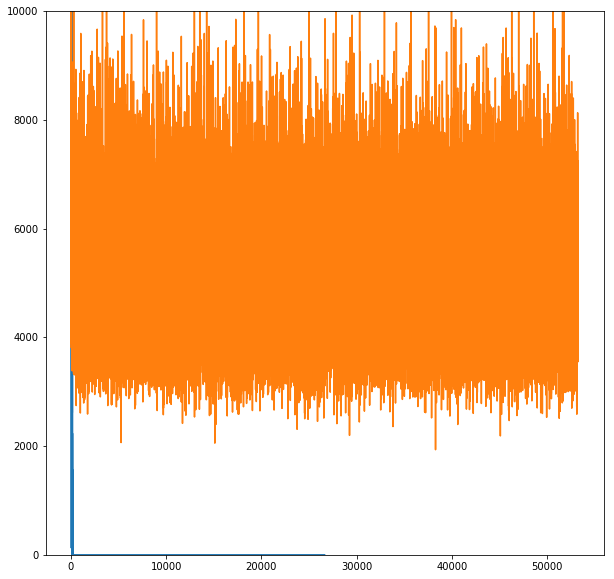

In [8]:
fig, axes = plt.subplots(1, 1, figsize=(10, 10))

axes.plot(encoder_losses)
axes.plot(decoder_losses)
plt.setp(axes, ylim=[0, 10000])


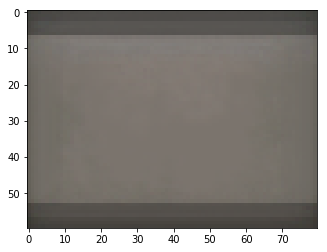

In [7]:
plt.imshow(predictions[-1][0, 10, :, :, :]/255)

In [17]:
def render_movie(frame_array, output_file, fps, max_pixel=255):
    n_frames = frame_array.shape[0]
    scaled_array = frame_array
    clipped_frames = np.minimum(np.maximum(scaled_array, 0), max_pixel).astype(np.uint8)
    clip = mpe.ImageSequenceClip(list(clipped_frames), fps=fps)
    clip.write_videofile(output_file)
    return clipped_frames

frame_array = render_movie(predictions[-1][0], 'test_lstm_pred.mp4', 5)

[MoviePy] >>>> Building video test_lstm_pred.mp4
[MoviePy] Writing video test_lstm_pred.mp4


100%|██████████| 64/64 [00:00<00:00, 2385.65it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: test_lstm_pred.mp4 



# Dated

In [4]:
def run_exp_ae(batchsize, num_epochs, data=None):
    
    if data is not None:
        video_inputs = tf.placeholder(dtype=tf.float32, shape=(None, 64, 60, 80, 3), name='inputs')
        video_outputs = tf.placeholder(dtype=tf.float32, shape=(None, 64, 60, 80, 3), name='outputs')
    else:
         video_inputs, video_outputs = load.inputs('training', batchsize, num_epochs)
            
    inputs = tf.reshape(video_inputs, (-1, 60, 80, 3))
    _, decoded_outputs = build_ae_model(video_inputs, encoder, decoder)

    decoded = tf.reshape(decoded_outputs, (-1, 64, 60, 80, 3))
    l2_weight = .02
    l2_vars = [v for v in tf.trainable_variables() if 'bias' not in v.name]
    l2_vars = [v for v in l2_vars if 'lstm' not in v.name]
    l2_term = tf.add_n([tf.nn.l2_loss(v) for v in l2_vars])
    
    loss = tf.reduce_mean(tf.pow(decoded - video_outputs, 2))
    train_step = tf.train.AdamOptimizer().minimize(loss + l2_weight*l2_term)
    
    saver = tf.train.Saver()
    init_global = tf.global_variables_initializer()
    init_local = tf.local_variables_initializer()
    
    coord = tf.train.Coordinator()
        
    with tf.Session() as sesh:
        sesh.run(init_global)
        sesh.run(init_local)
        threads = tf.train.start_queue_runners(sess=sesh, coord=coord)

        losses = []
        predictions = []
        
        if data is not None:
            X = data[:, :-1, :, :, :]
            y = data[:, 1:, :, :, :]
            for epoch in range(num_epochs):
                batch_no = 0
                for X_batch, y_batch in iterate_minibatches(X, y, batchsize=batchsize, shuffle=True):
                    _, loss_value = sesh.run(
                        [train_step, loss], 
                        feed_dict={video_inputs: X_batch, video_outputs: y_batch}
                    )

                    losses.append(loss_value / batchsize)
                    if epoch % 10 == 0:
                        if batch_no == 0:
                            pred = sesh.run(decoded, feed_dict={video_inputs: X_batch, video_outputs: y_batch})
                            predictions.append(pred)

                print('Epoch {} loss: {:.8f}'.format(epoch, loss_value))
            
            saver.save(sesh, 'prototype-lstm-dummydata')
        
        else:
            try:
                step = 0

                while not coord.should_stop():
                    _, loss_value, prediction = sesh.run([train_step, loss, decoded])
                    losses.append(loss_value)

                    if step % 500 == 0:
                        print('Step {} loss:\t{:.8f}'.format(step, loss_value))
                        predictions.append(prediction)
                        
                    if step > 1000:
                        break
                    
                    step += 1

            except tf.errors.OutOfRangeError:
                print('Done; loss:\t{:.8f}'.format(loss_value))

            finally:
                coord.request_stop()

            coord.join(threads)
            saver.save(sesh, 'prototype-lstm')
        
    return losses, predictions

video_mask = np.ones((1024, 65, 3, 60, 80), dtype=np.uint8)
frame = np.eye(60, dtype=np.uint8)
padded = np.pad(frame, ((0, 0), (0, 20)), 'constant')

video = video_mask * padded
video = video.transpose((0, 1, 3, 4, 2))

losses, predictions = run_exp_ae(16, 3)

[1024, 54, 74, 32] 127872
Step 0 loss:	0.41123143
Step 500 loss:	0.19287437
Step 1000 loss:	0.20916134


In [6]:
losses = run_training(10, 4)

[256, 54, 74, 32] 127872
[256, 54, 74, 32] 127872
132.028131
Step 0 loss: 0.2349
Step 500 loss: 0.2951
Step 1000 loss: 0.2732
Step 1500 loss: 0.2971
Step 2000 loss: 0.3299
Step 2500 loss: 0.2013
Step 3000 loss: 0.2342
Step 3500 loss: 0.2449
Step 4000 loss: 0.2932
Step 4500 loss: 0.2911
Done; loss: 4997.0000
